200284B

Q1

Radius : 9.742360096347989
Center Coordinates: (106.0, 256.0)


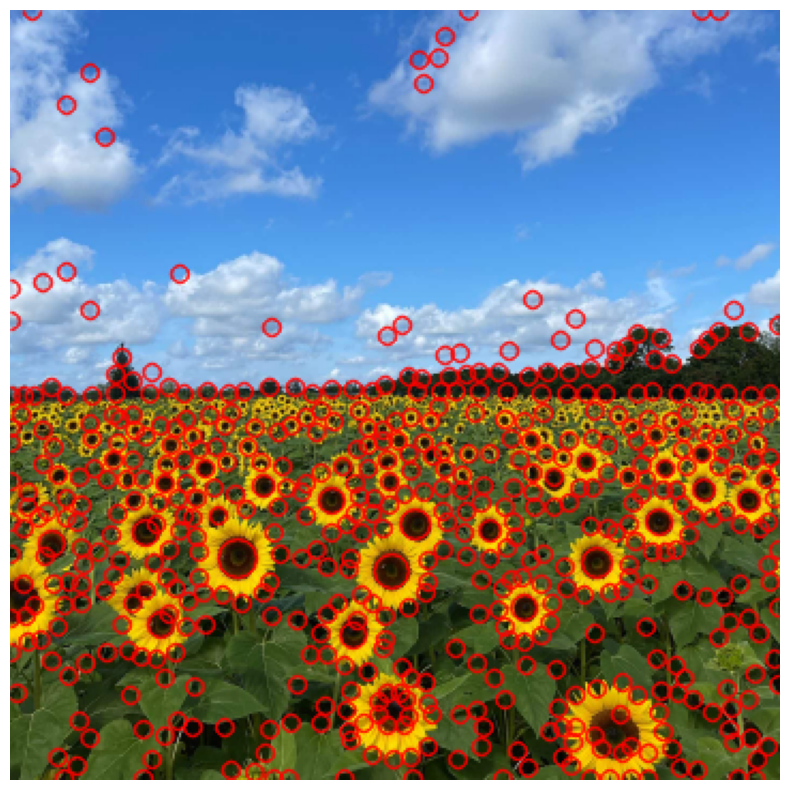

In [45]:
import cv2 as cv
import numpy as np
from skimage.feature import blob_log
import matplotlib.pyplot as plt
from math import sqrt

# Read the image
img = cv.imread('images/the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)

# Apply Gaussian blur to reduce noise
blurred = cv.GaussianBlur(gray, (9,9), 0.1)
laplacian = cv.Laplacian(blurred, cv.CV_64F)

# Define parameters for blob detection
min_sigma = 3
max_sigma = 10
threshold = 4

# Detect blobs using Laplacian of Gaussians
blobs = blob_log(laplacian, min_sigma=min_sigma,max_sigma=max_sigma, threshold=threshold)

blobs[:, 2] = blobs[:, 2] * sqrt(2)

max_radius_index = np.argmax(blobs[:, 2])
largest_circle_params = blobs[max_radius_index]
y, x, r = largest_circle_params

# print the radius and centre cordinates of the largest circle
print(f"Radius : {r}")
print(f"Center Coordinates: ({x}, {y})")

# Draw circles on the original grayscale image
for blob in blobs:
    y, x, r = blob  # Blob format is (y, x, r)
    cv.circle(img, (int(x), int(y)), int(r), (0,0,255),thickness=1, lineType=cv.LINE_AA)  # Draw circles in white

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

in the above code, by applying the Laplasian of Gaussians, it has reduced noise and enhanced the image features so that it can detect circular shapes. minimum and maximum sigma values and a threshold, are carefully chosen to capture circles of varying sizes while minimizing false detections.

Q2

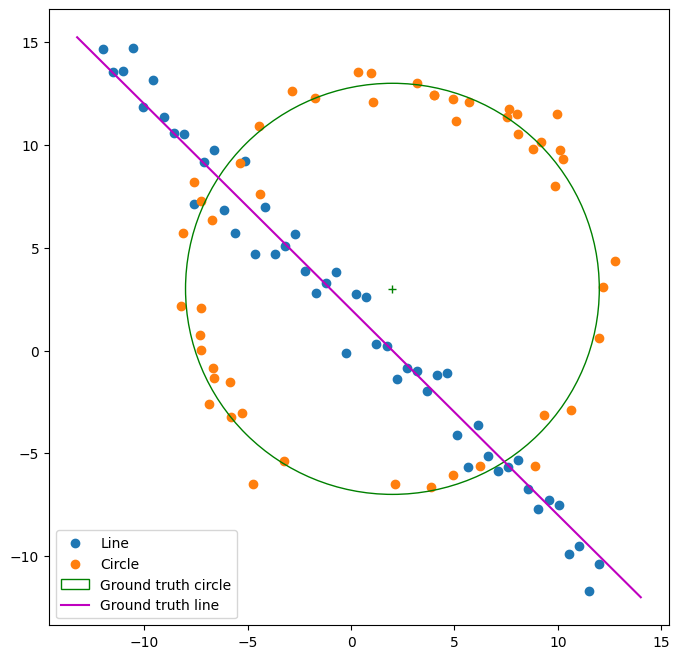

In [54]:
# Generation of a Noisy Point Set Conforming to a Line and a Circle
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import tikzplotlib

# np . random. seed ( 0 )
N = 100
half_n = N//2

r = 10
x0_gt , y0_gt = 2 , 3 # Center
s = r /16
t = np.random. uniform(0 , 2*np . pi , half_n )
n = s*np . random. randn ( half_n )
x , y = x0_gt + ( r + n)*np . cos ( t ) , y0_gt + ( r + n)*np . sin ( t )
X_circ = np . hstack ( ( x.reshape ( half_n , 1 ) , y.reshape ( half_n , 1 ) ) )
s = 1.
m, b = -1, 2

x = np .linspace(-12, 12 , half_n )
y = m*x + b + s*np . random. randn ( half_n )

X_line = np . hstack ( ( x . reshape ( half_n , 1 ) , y . reshape ( half_n , 1 ) ) )

X = np . vstack ( ( X_circ , X_line ) ) # All points

fig , ax = plt . subplots (1 ,1 , figsize =(8 ,8) )

ax.scatter( X_line [ : , 0 ] , X_line [ : , 1 ] , label= 'Line')
ax.scatter( X_circ [ : , 0 ] , X_circ [ : , 1 ] , label= 'Circle' )

circle_gt = plt.Circle ( ( x0_gt , y0_gt ) , r , color= 'g' , fill =False , label= 'Ground truth circle' )
ax.add_patch ( circle_gt )
ax.plot( ( x0_gt ) , ( y0_gt ) , '+' , color= 'g' )

x_min , x_max = ax.get_xlim ( )
x_ = np.array ( [ x_min , x_max ] )

y_ = m*x_ + b

plt . plot ( x_ , y_ , color= 'm' , label= 'Ground truth line' )
plt . legend ( )

a

In [55]:
import numpy as np

# Function to calculate the line parameters [a, b, d] from two points
def calculate_line_parameters(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    a = y2 - y1
    b = x1 - x2
    d = x2 * y1 - x1 * y2
    norm = np.sqrt(a ** 2 + b ** 2)
    a /= norm
    b /= norm
    return a, b, d

# Function to calculate the distance of a point from a line
def point_to_line_distance(a, b, d, point):
    x, y = point
    return np.abs(a * x + b * y - d) / np.sqrt(a ** 2 + b ** 2)

# Function to fit a line using RANSAC
def fit_line_ransac(points, num_iterations, error_threshold, min_consensus):
    best_line = None
    best_inliers = []

    for _ in range(num_iterations):
        # Randomly sample two points from the data
        sample_indices = np.random.choice(len(points), 2, replace=False)
        sample_points = points[sample_indices]

        # Compute the line parameters [a, b, d]
        a, b, d = calculate_line_parameters(sample_points[0], sample_points[1])

        # Calculate the error (perpendicular distance) for all points
        errors = np.array([point_to_line_distance(a, b, d, point) for point in points])

        # Find inliers based on the error threshold
        inliers = np.where(errors < error_threshold)[0]

        # Check if we have a new best model with more inliers
        if len(inliers) >= min_consensus and len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_line = (a, b, d)

    return best_line, best_inliers

b

In [58]:
import numpy as np

# Function to calculate the circle parameters [x, y, r] from 3 points
def calculate_circle_parameters(points):
    x1, y1 = points[0]
    x2, y2 = points[1]
    x3, y3 = points[2]
    
    D = 2 * (x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))
    Ux = ((x1**2 + y1**2) * (y2 - y3) + (x2**2 + y2**2) * (y3 - y1) + (x3**2 + y3**2) * (y1 - y2)) / D
    Uy = ((x1**2 + y1**2) * (x3 - x2) + (x2**2 + y2**2) * (x1 - x3) + (x3**2 + y3**2) * (x2 - x1)) / D
    
    r = np.sqrt((x1 - Ux)**2 + (y1 - Uy)**2)
    
    return Ux, Uy, r

# Function to fit a circle using RANSAC
def fit_circle_ransac(points, num_iterations, error_threshold, min_consensus):
    best_circle = None
    best_inliers = []

    for _ in range(num_iterations):
        # Randomly sample three points from the data
        sample_indices = np.random.choice(len(points), 3, replace=False)
        sample_points = points[sample_indices]

        # Compute the circle parameters [x, y, r]
        x, y, r = calculate_circle_parameters(sample_points)

        # Calculate the radial error for all points
        radial_errors = np.abs(np.sqrt((points[:, 0] - x)**2 + (points[:, 1] - y)**2) - r)

        # Find inliers based on the radial error threshold
        inliers = np.where(radial_errors < error_threshold)[0]

        # Check if we have a new best model with more inliers
        if len(inliers) >= min_consensus and len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_circle = (x, y, r)

    return best_circle, best_inliers


c

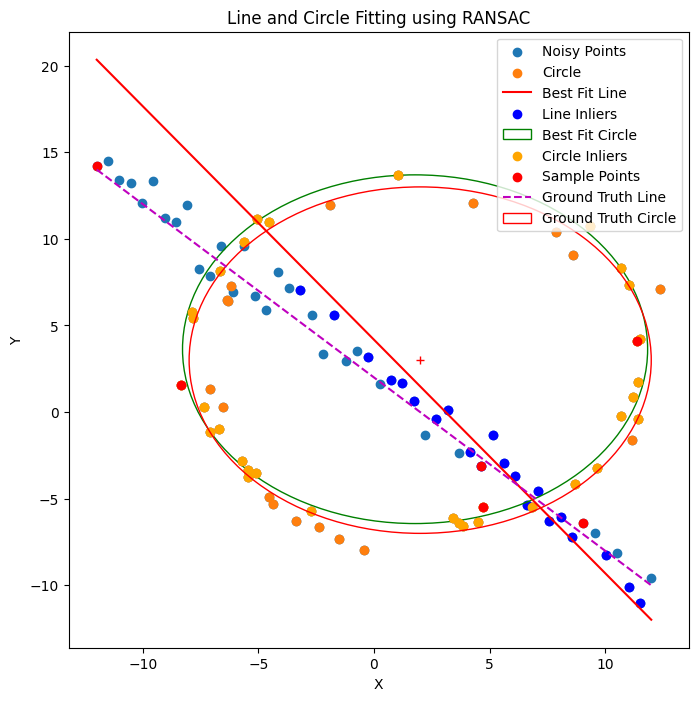

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle


# Generate a noisy point set conforming to a line and a circle
np.random.seed(0)
N = 100
half_n = N // 2

r = 10
x0_gt, y0_gt = 2, 3  # Center
s = r / 16
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

s = 1.
m, b = -1, 2

x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)

X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line))  # All points



# Estimate the line using RANSAC
num_iterations_line = 1000
error_threshold_line = 0.9  
min_consensus_line = 20     

best_line, line_inliers = fit_line_ransac(X_line, num_iterations_line, \
    error_threshold_line, min_consensus_line)

# Estimate the circle using RANSAC
num_iterations_circle = 1000
error_threshold_circle = 0.5  
min_consensus_circle = 20     

best_circle, circle_inliers = fit_circle_ransac(X_circ, num_iterations_circle,\
     error_threshold_circle, min_consensus_circle)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))


ax.scatter(X[:, 0], X[:, 1], label='Noisy Points')
ax.scatter( X_circ[ : , 0 ] , X_circ [ : , 1 ] , label= 'Circle' )

# Plot the best-fit line and its inliers
if best_line is not None:  # Check if the line was successfully estimated
    x_min, x_max = np.min(X_line[:, 0]), np.max(X_line[:, 0])
    y_min, y_max = best_line[2] / best_line[1] - best_line[0] * x_min / best_line[1], \
                   best_line[2] / best_line[1] - best_line[0] * x_max / best_line[1]
    ax.plot([x_min, x_max], [y_min, y_max], color='red', label='Best Fit Line')
    ax.scatter(X_line[line_inliers, 0], X_line[line_inliers, 1], color='blue', label='Line Inliers')

# Plot the best-fit circle and its inliers
if best_circle is not None:  # Check if the circle was successfully estimated
    x_circle, y_circle, r_circle = best_circle
    circle = Circle((x_circle, y_circle), r_circle, color='green', fill=False, label='Best Fit Circle')
    ax.add_patch(circle)
    ax.scatter(X_circ[circle_inliers, 0], X_circ[circle_inliers, 1], color='orange', label='Circle Inliers')

# Plot the sample of three points used for line and circle estimation
if best_line is not None and best_circle is not None:
    sample_points = np.vstack((X_line[np.random.choice(len(X_line), 3, replace=False)],
                               X_circ[np.random.choice(len(X_circ), 3, replace=False)]))
    ax.scatter(sample_points[:, 0], sample_points[:, 1], color='red', label='Sample Points')

# Add the ground truth line
ax.plot(x, m * x + b, color='m', linestyle='--', label='Ground Truth Line')

# Add the ground truth circle
circle_gt = Circle((x0_gt, y0_gt), r, color='red', fill=False, label='Ground Truth Circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='red')

# Add legend and labels
ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Line and Circle Fitting using RANSAC')

plt.show()


Q3

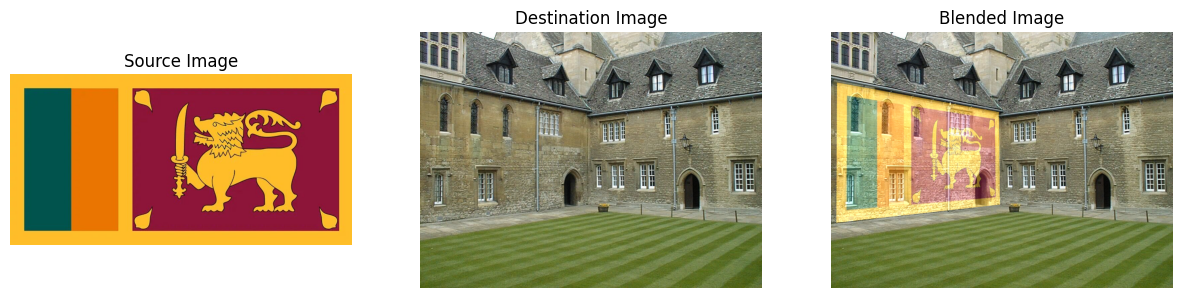

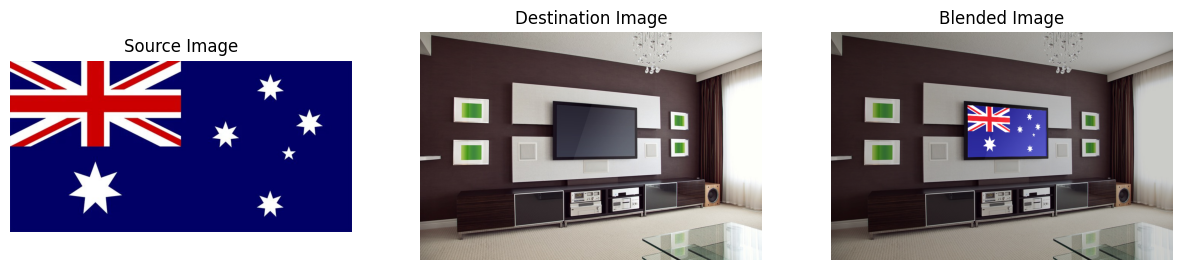

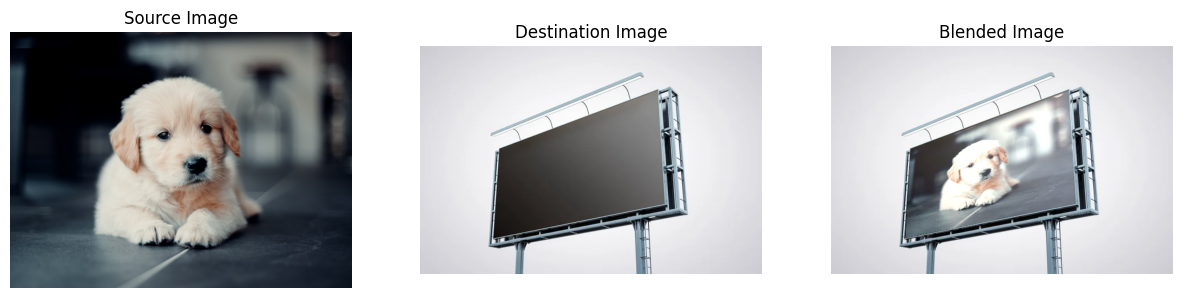

In [40]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

images = [cv.imread('images/building.jpg'),cv.imread('images/tv.jpg'),cv.imread('images/billboard.jpg')]
coffs = [(1, 0.5, 0.2), (0.8, 1, 0), (1, 1, 0)]
source_img = [cv.imread('images/Sri Lanka flag.jpg'),cv.imread('images/Austrailia flag.jpg'),cv.imread('images/dog.jpg')]
for i in range(len(images)):
    flag=source_img[i]
    points = []
    clicks = 0
    def click(event, x, y, flags, params):
        if event == cv.EVENT_LBUTTONDOWN:
            points.append([x,y])
    img = images[i]
    cv.imshow('image', img)
    cv.setMouseCallback('image', click)
    cv.waitKey(0)
    cv.destroyAllWindows()

    if flag is None:
        print(f"Error: Could not load source image '{source_img[i]}'")
        continue
    
    w, h = flag.shape[1], flag.shape[0]
    pts_src = np.array([[0, 0], [w-1, 0], [w-1, h-1], [0, h-1]])
    pts_dst = np.array(points)
    h, status = cv.findHomography(pts_src, pts_dst)
    im_out = cv.warpPerspective(flag, h, (img.shape[1], img.shape[0]))
    blended_img = cv.addWeighted(img, coffs[i][0], im_out, coffs[i][1], coffs[i][2])
    #blended_img = cv.addWeighted(img, 1, im_out, 0.4, 0.2)
    im=[flag, img, blended_img]
    cv.imshow("Blended Image", blended_img)
    cv.waitKey(0)
    cv.destroyAllWindows()

    fig, ax = plt.subplots(1, 3, figsize=(15, 10), facecolor="white")
    titles = ['Source Image','Destination Image', 'Blended Image']
    for j in range(3):
        transformed_img_ = cv.cvtColor(im[j], cv.COLOR_BGR2RGB)
        ax[j].axis('off')
        ax[j].imshow(transformed_img_)
        ax[j].set_title(titles[j])
    

plt.show()



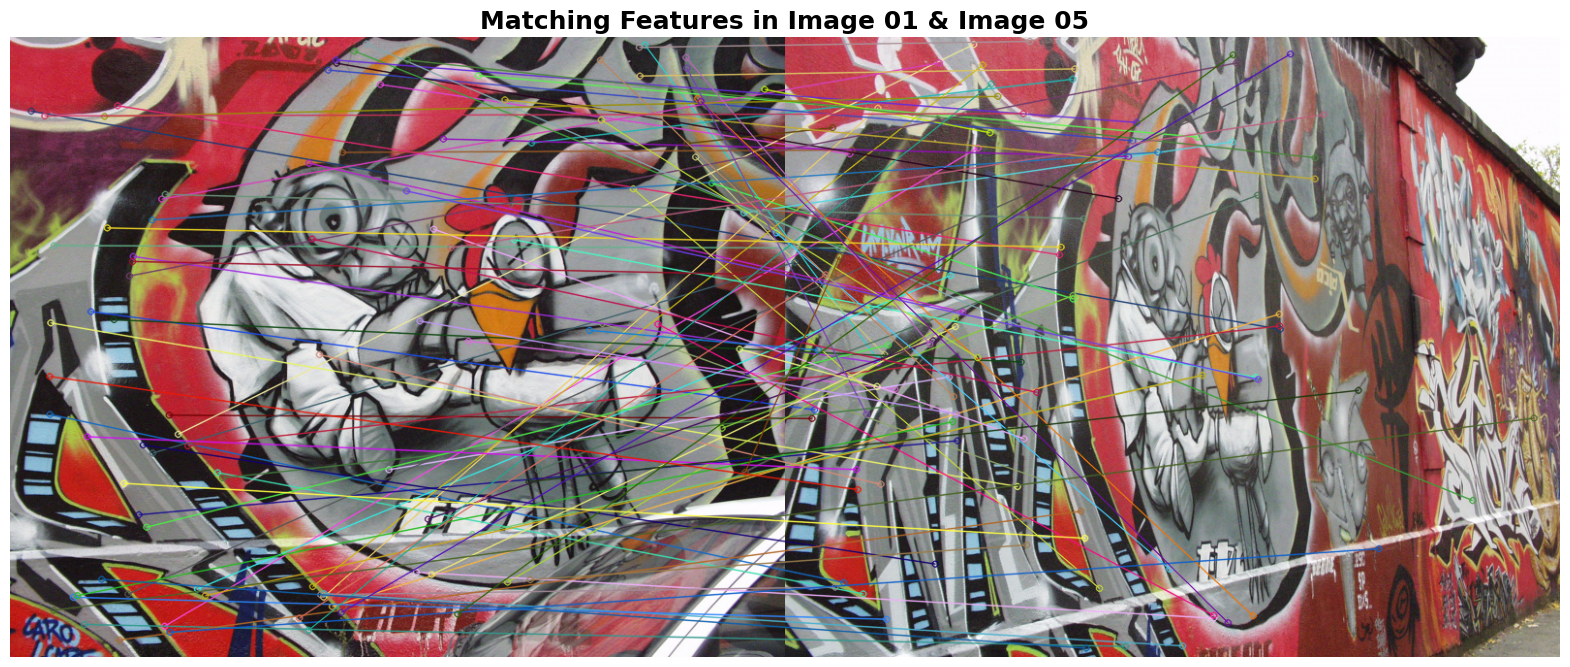

In [47]:
# Import the necessary libraries
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

# Read the images img1.ppm and img5.ppm
img1, img5 = cv.imread("images/img1.ppm"), cv.imread("images/img5.ppm")

# Create a SIFT (Scale-Invariant Feature Transform) detector
sift = cv.SIFT_create()

# Create a Brute-Force Matcher with L2 (Euclidean distance) norm and cross-checking
bf = cv.BFMatcher(cv.NORM_L2, crossCheck=True)

# Detect and compute key points and descriptors for both images
kp1, des1 = sift.detectAndCompute(img1, None)
kp5, des5 = sift.detectAndCompute(img5, None)

matches = bf.match(des1, des5)

matches = sorted(matches, key=lambda x: x.distance)

# Draw the top 100 matching features between img1 and img5
img3 = cv.drawMatches(img1, kp1, img5, kp5, matches[:100], img5, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)


fig = plt.figure(figsize=(20, 20))
plt.imshow(cv.cvtColor(img3, cv.COLOR_BGR2RGB))
plt.title("Matching Features in Image 01 & Image 05", fontweight="bold", fontsize=18)
plt.axis('off')
plt.show()


Computed Homography =  
 [[ 6.23815815e-01  4.58538915e-02  2.23336858e+02]
 [ 2.26700418e-01  1.13108290e+00 -2.07217320e+01]
 [ 5.01479808e-04 -7.88768033e-05  1.00000000e+00]]
Provided Homography =  
    6.2544644e-01   5.7759174e-02   2.2201217e+02
   2.2240536e-01   1.1652147e+00  -2.5605611e+01
   4.9212545e-04  -3.6542424e-05   1.0000000e+00



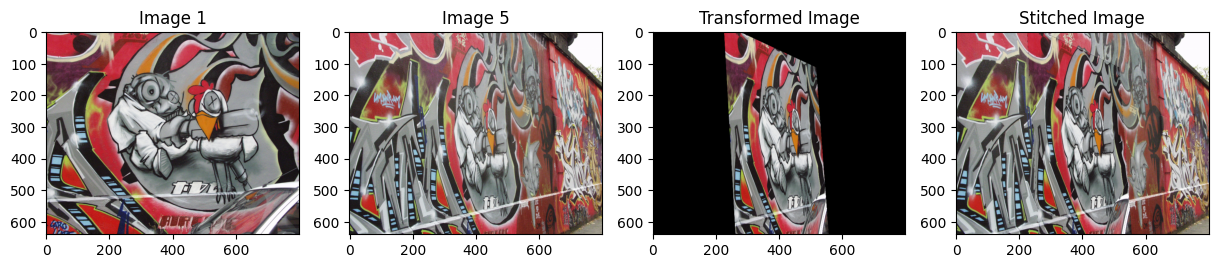

In [53]:
from random import randint

img2, img3, img4 = cv.imread("images/img2.ppm"), cv.imread("images/img3.ppm"), cv.imread("images/img4.ppm")

images = [img1, img2, img3, img4, img5]
image_gray= [cv.cvtColor(img, cv.COLOR_BGR2GRAY) for img in images]

def random_number(n, t):
    l = np.random.randint(n, size=t)
    m = np.zeros(np.shape(l))
    
    for i in range(len(l)):
        m[i] = np.sum(l==l[i])
    if np.sum(m) == len(m):
        return l
    else:
        return random_number(n,t)
    
def Homography(p1, p2):
    x1, y1, x2, y2, x3, y3, x4, y4 = p2[0], p2[1], p2[2], p2[3], p2[4], p2[5], p2[6], p2[7] 
    x1T, x2T, x3T, x4T = p1[0], p1[1], p1[2], p1[3]
    zero_matrix = np.array([[0], [0], [0]])

    matrix_A = np.concatenate((np.concatenate((zero_matrix.T,x1T, -y1*x1T), axis = 1),\
         np.concatenate((x1T, zero_matrix.T, -x1*x1T), axis = 1),
                            np.concatenate((zero_matrix.T,x2T, -y2*x2T), axis = 1),\
                                 np.concatenate((x2T, zero_matrix.T, -x2*x2T), axis = 1),
                            np.concatenate((zero_matrix.T,x3T, -y3*x3T), axis = 1),\
                                 np.concatenate((x3T, zero_matrix.T, -x3*x3T), axis = 1),
                            np.concatenate((zero_matrix.T,x4T, -y4*x4T), axis = 1), \
                                np.concatenate((x4T, zero_matrix.T, -x4*x4T), axis = 1)), \
                                    axis = 0, dtype=np.float64)
    W, v = np.linalg.eig(((matrix_A.T)@matrix_A))
    temph= v[:,np.argmin(W)]
    H = temph.reshape((3,3))
    return H

p, s, e = 0.99, 4, 0.5
N = int(np.ceil(np.log(1-p)/np.log(1-((1-e)**s))))
Hs = []
for i in range(4):
    sift = cv.SIFT_create()
    key_points_1, descriptors_1 = sift.detectAndCompute(image_gray[i],None) #sifting
    key_points_2, descriptors_2 = sift.detectAndCompute(image_gray[i+1],None)
    bf_match = cv.BFMatcher(cv.NORM_L1, crossCheck=True)  #feature matching
    matches = sorted(bf_match.match(descriptors_1, descriptors_2), key = lambda x:x.distance)

    Source_Points = [key_points_1[k.queryIdx].pt for k in matches]
    Destination_Points = [key_points_2[k.trainIdx].pt for k in matches]
    threshold, best_inliers, best_H = 2, 0, 0

    for i in range(N):
        ran_points = random_number(len(Source_Points)-1, 4)
        f_points = []
        for j in range(4):
            f_points.append(np.array([[Source_Points[ran_points[j]][0], Source_Points[ran_points[j]][1], 1]]))

        t_points = []
        for j in range(4):
            t_points.append(Destination_Points[ran_points[j]][0]) 
            t_points.append(Destination_Points[ran_points[j]][1])

        H = Homography(f_points,t_points)
        
        inliers = 0 
        for k in range(len(Source_Points)):
            X = [Source_Points[k][0], Source_Points[k][1], 1]
            HX = H @ X
            HX /= HX[-1]
            err = np.sqrt(np.power(HX[0]-Destination_Points[k][0], 2) + np.power(HX[1]-Destination_Points[k][1], 2))
            if err < threshold:
                inliers +=1
        if inliers > best_inliers:
            best_inliers = inliers
            best_H = H 
    Hs.append(best_H)

H1_H5 = Hs[3] @ Hs[2] @ Hs[1] @ Hs[0]
H1_H5 /= H1_H5[-1][-1]

print("Computed Homography = ","\n", H1_H5)
print("Provided Homography = ","\n", open("H1to5p.txt",'r').read())

transformed_im = cv.warpPerspective(img1, H1_H5, (np.shape(img5)[1], np.shape(img5)[0]))
ret,threshold = cv.threshold(transformed_im,10,1,cv.THRESH_BINARY_INV)
img_tresholded=np.multiply(img5,threshold)
img_final=cv.addWeighted(img_tresholded,1,transformed_im,1,0)

fig, ax = plt.subplots(1,4,figsize=(15,15))
ax[0].imshow(cv.cvtColor(img1,cv.COLOR_BGR2RGB)), ax[0].set_title("Image 1")
ax[1].imshow(cv.cvtColor(img5,cv.COLOR_BGR2RGB)), ax[1].set_title("Image 5")
ax[2].imshow(cv.cvtColor(transformed_im,cv.COLOR_BGR2RGB)), ax[2].set_title("Transformed Image")
ax[3].imshow(cv.cvtColor(img_final,cv.COLOR_BGR2RGB)), ax[3].set_title("Stitched Image")
plt.show()



The provided code accomplishes the task of stitching two graffiti images, img1.ppm and img5.ppm, by employing SIFT feature matching and RANSAC-based homography estimation. It begins by detecting and matching features between the two images, followed by robust homography calculation to align them. The code efficiently combines homographies from adjacent images to create a seamless transformation from img1 to img5. It then generates a binary mask to separate the foreground and background and blends the images together to produce a final stitched result. The code also offers visualizations of the original images, the transformed image, and the stitched output, and it compares the computed homography with the provided Homography matrix. 